# Assignment 1-2: Support Vector Machine

## Multiclass Support Vector Machine exercise


In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient


## CIFAR-10 Data Loading and Preprocessing

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
import download

In [52]:
# Load the raw CIFAR-10 data.
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
download.maybe_download_and_extract(url,download_dir)

Data has apparently already been downloaded and unpacked.


In [53]:
def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y
    



In [54]:
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


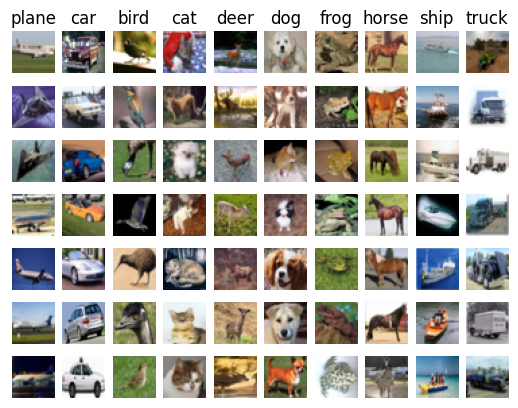

In [55]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [56]:
def load_CIFAR10(ROOT):
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'cifar-10-batches-py', 'data_batch_%d' % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    X_train = np.concatenate(xs)
    y_train = np.concatenate(ys)
    del X, Y
    X_test, y_test = load_CIFAR_batch(os.path.join(ROOT, 'cifar-10-batches-py', 'test_batch'))
    return X_train, y_train, X_test, y_test



In [57]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = ''
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [58]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(50000, 3072) (10000, 3072)


In [59]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


In [60]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


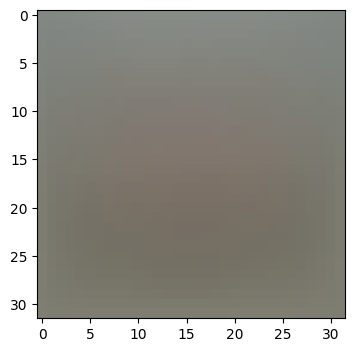

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [61]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

You need to complete `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [70]:
from builtins import range
import numpy as np
from random import shuffle
from past.builtins import xrange

def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape) # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1 # note delta = 1
            if margin > 0:
                loss += margin

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_train

    # Add regularization to the loss.
    loss += reg * np.sum(W * W)

    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather than first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################
    # *****START OF YOUR CODE*****
    # Get dimensions from input data
    N = X.shape[0]  # Number of training examples
    D = X.shape[1]  # Number of features
    C = W.shape[1]  # Number of classes

    # Compute scores
    scores = X.dot(W)

    # Get the correct class scores
    correct_class_scores = scores[np.arange(N), y].reshape(-1, 1)

    # Compute margins
    margins = np.maximum(0, scores - correct_class_scores + 1)
    margins[np.arange(N), y] = 0  # Ignore the correct class margins

    # Compute the loss
    loss = np.sum(margins) / N
    loss += reg * np.sum(W * W)  # Add regularization

    # Compute gradient
    binary = margins > 0
    row_sum = np.sum(binary, axis=1)
    binary[np.arange(N), y] = -row_sum

    dW = X.T.dot(binary) / N  # Average over number of samples
    dW += 2 * reg * W  # Add regularization
    
    pass

    # *****END OF YOUR CODE*****
    
    return loss, dW

In [71]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.620547


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [64]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 40.425086 analytic: -0.351503, relative error: 1.000000e+00
numerical: -14.586206 analytic: -0.168997, relative error: 9.770932e-01
numerical: -45.354676 analytic: -4.149954, relative error: 8.323408e-01
numerical: 13.751217 analytic: -2.146534, relative error: 1.000000e+00
numerical: -12.515354 analytic: -2.581734, relative error: 6.579826e-01
numerical: 9.029046 analytic: -3.226069, relative error: 1.000000e+00
numerical: 0.158753 analytic: -0.629100, relative error: 1.000000e+00
numerical: -50.274457 analytic: -1.344906, relative error: 9.478914e-01
numerical: 5.284455 analytic: -0.207360, relative error: 1.000000e+00
numerical: -14.675406 analytic: -4.199753, relative error: 5.549968e-01
numerical: -10.491644 analytic: -2.541830, relative error: 6.099535e-01
numerical: -14.602083 analytic: -0.286924, relative error: 9.614583e-01
numerical: -21.425244 analytic: -3.848210, relative error: 6.954742e-01
numerical: -41.961788 analytic: 0.704010, relative error: 1.000000e+00
n

Complete the implementation of svm_loss_vectorized, and compute the gradient of the loss function in a vectorized way.

In [90]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    # *****START OF YOUR CODE*****
    
    num_train = X.shape[0]

    # Step 1: Compute the scores
    scores = X.dot(W)  # Shape (N, C)

    # Step 2: Select the correct class scores
    y = y.reshape(-1)  # Flatten y to shape (N,) if needed
    correct_class_scores = scores[np.arange(num_train), y].reshape(-1, 1)  # Shape (N, 1)

    # Step 3: Compute the margins
    margins = np.maximum(0, scores - correct_class_scores + 1)  # Shape (N, C)
    margins[np.arange(num_train), y] = 0  # Do not consider correct class in the loss

    # Step 4: Compute the loss
    loss = np.sum(margins) / num_train  # Average the loss
    loss += reg * np.sum(W * W)  # Add regularization to the loss

    pass

    # *****END OF YOUR CODE*****

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    # *****START OF YOUR CODE*****
    # Step 5: Compute the gradient (dW)
    binary = np.zeros_like(margins)
    binary[margins > 0] = 1

    row_sum = np.sum(binary, axis=1)
    binary[np.arange(num_train), y] = -row_sum  # Correct class gradient adjustment

    dW = X.T.dot(binary) / num_train  # Compute gradient

    dW += 2 * reg * W  # Add regularization to the gradient

    # *****END OF YOUR CODE*****

    return loss, dW


In [91]:
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.620547


In [92]:
import time
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.062095s
Vectorized loss and gradient: computed in 0.001499s
difference: 3179.415785


### Discussion